In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import optuna
import numpy as np
import matplotlib.pyplot as plt

# Global definitions for common parameters
input_size = 5
output_size = 2
epsilon_start = 1.0
epsilon_end = 0.01
gamma = 0.99
num_episodes = 200

# Define DQN models for FFNN, RNN, and LSTM
class FFNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class RNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, layer_num=2):
        super(RNN, self).__init__()
        self.rnnLayer = nn.RNN(in_dim, hidden_dim, layer_num, batch_first=True)
        self.relu = nn.ReLU()
        self.fcLayer = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        out, _ = self.rnnLayer(x)
        out = self.relu(out[:, -1, :])  # Take the output of the last time step
        out = self.fcLayer(out)
        return out

class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, layer_num=3):
        super(LSTM, self).__init__()
        self.lstmLayer = nn.LSTM(in_dim, hidden_dim, layer_num, batch_first=True, dropout=0.2)
        self.relu = nn.ReLU()
        self.fcLayer1 = nn.Linear(hidden_dim, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fcLayer2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        out, _ = self.lstmLayer(x)
        out = self.relu(out[:, -1, :])  # Take the output of the last time step
        out = self.relu(self.fcLayer1(out))  # First fully connected layer with ReLU
        if out.size(0) > 1:  # Apply batch normalization only if batch size > 1
            out = self.batch_norm(out)
        out = self.fcLayer2(out)  # Second fully connected layer
        return out

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return zip(*random.sample(self.buffer, batch_size))

    def __len__(self):
        return len(self.buffer)

class IteratedPrisonersDilemma:
    def __init__(self):
        self.num_actions = 2
        self.payoff_matrix = np.array([
            [4, -10],
            [10, 0]
        ])

    def step(self, action1, action2):
        reward1 = self.payoff_matrix[action1][action2]
        reward2 = self.payoff_matrix[action2][action1]
        return reward1, reward2

def select_action(state, epsilon, policy_net, output_size):
    if np.random.rand() < epsilon:
        return np.random.randint(output_size)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()

def update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma):
    if len(replay_buffer) < batch_size:
        return
    states, actions, rewards, next_states = replay_buffer.sample(batch_size)
    states = torch.tensor(states, dtype=torch.float32).view(batch_size, 1, -1)
    actions = torch.tensor(actions, dtype=torch.long)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32).view(batch_size, 1, -1)

    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = target_net(next_states).max(1)[0].detach()
    expected_q_values = rewards + gamma * next_q_values

    loss = nn.functional.mse_loss(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def train_dqn(trial, model_class):
    # Hyperparameters to optimize
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.99, 0.999)
    target_update = trial.suggest_int('target_update', 5, 20)

    policy_net = model_class(input_size, hidden_size, output_size)
    target_net = model_class(input_size, hidden_size, output_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=10000)
    ipd_env = IteratedPrisonersDilemma()
    total_rewards = []

    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        for t in range(100):
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)
            action = select_action(state, epsilon, policy_net, output_size)
            opponent_action = state[0]
            reward, opponent_reward = ipd_env.step(action, opponent_action)
            next_state = [action, opponent_action, reward, opponent_reward, t]
            replay_buffer.push(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma)
            if t % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    return avg_reward

# Train with Optuna
def optimize_model(model_class):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: train_dqn(trial, model_class), n_trials=50)
    print(f"Best trial: {study.best_trial.params}")
    return study.best_trial.params

def play_ipd(policy_net, num_episodes, strategy, epsilon=0.1):
    ipd_env = IteratedPrisonersDilemma()
    total_rewards = []
    opponent_rewards = []
    agent_cooperations = []
    mutual_cooperations = []

    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        opponent_total_reward = 0
        opponent_last_action = 0
        grim_trigger_active = False
        episode_agent_cooperations = 0
        episode_mutual_cooperations = 0

        for t in range(100):
            if strategy == "tft":
                opponent_action = state[0]
            elif strategy == "random":
                opponent_action = np.random.choice([0, 1])
            elif strategy == "grim_trigger":
                if grim_trigger_active:
                    opponent_action = 1
                else:
                    opponent_action = 0
                    if state[1] == 1:
                        grim_trigger_active = True
            elif strategy == "wsls":
                if t > 0 and state[2] < state[3]:
                    opponent_action = 1 - opponent_last_action
                else:
                    opponent_action = opponent_last_action
            elif strategy == "always_cooperate":
                opponent_action = 0
            elif strategy == "always_defect":
                opponent_action = 1
            else:
                raise ValueError("Invalid strategy")
            opponent_last_action = opponent_action

            if np.random.rand() < epsilon:
                action = np.random.randint(ipd_env.num_actions)
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            reward, opponent_reward = ipd_env.step(action, opponent_action)
            next_state = [action, opponent_action, reward, opponent_reward, t]
            state = next_state
            total_reward += reward
            opponent_total_reward += opponent_reward

            if action == 0:
                episode_agent_cooperations += 1
            if action == 0 and opponent_action == 0:
                episode_mutual_cooperations += 1

        total_rewards.append(total_reward)
        opponent_rewards.append(opponent_total_reward)
        agent_cooperations.append(episode_agent_cooperations)
        mutual_cooperations.append(episode_mutual_cooperations)

    avg_total_reward = np.mean(total_rewards)
    mutual_cooperation_percentage = np.mean(mutual_cooperations) / 100.0
    print(f"Average Total Reward over {num_episodes} episodes: {avg_total_reward}")
    print(f"Percentage of Mutual Cooperation: {mutual_cooperation_percentage}")

    return total_rewards, opponent_rewards, agent_cooperations, mutual_cooperations

def test_against_strategies(model_class, params, num_episodes=200):
    policy_net = train_model(model_class, params)
    strategies = ["tft", "random", "grim_trigger", "always_cooperate", "always_defect"]
    results = {}

    for strategy in strategies:
        print(f"Testing against {strategy} strategy")
        results[strategy] = play_ipd(policy_net, num_episodes, strategy)

        # Plot total rewards
        agent_rewards, opponent_rewards, _, mutual_cooperations = results[strategy]
        plt.figure(figsize=(12, 6))
        plt.plot(agent_rewards, label='Agent Rewards per Episode')
        plt.plot(opponent_rewards, label='Opponent Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.title(f'Total Rewards per Episode against {strategy.upper()}')
        plt.show()

        # Plot mutual cooperations vs agent rewards
        plt.figure(figsize=(12, 6))
        plt.plot(mutual_cooperations, label='Mutual Cooperations per Episode')
        plt.plot(agent_rewards, label='Agent Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.title(f'Mutual Cooperations vs Agent Rewards per Episode against {strategy.upper()}')
        plt.show()

    return results

# Define the train_model function based on the previous code
def train_model(model_class, params):
    hidden_size = params['hidden_size']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epsilon_decay = params['epsilon_decay']
    target_update = params['target_update']

    policy_net = model_class(input_size, hidden_size, output_size)
    target_net = model_class(input_size, hidden_size, output_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=10000)
    ipd_env = IteratedPrisonersDilemma()

    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        for t in range(100):
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)
            action = select_action(state, epsilon, policy_net, output_size)
            opponent_action = state[0]
            reward, opponent_reward = ipd_env.step(action, opponent_action)
            next_state = [action, opponent_action, reward, opponent_reward, t]
            replay_buffer.push(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma)
            if t % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    return policy_net


[I 2024-08-21 06:52:28,778] A new study created in memory with name: no-name-b43dfe87-e303-4cd5-b5b9-ad4da67758fb


Training and testing FFNN...


/tmp/ipykernel_34/2130839232.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/tmp/ipykernel_34/2130839232.py:127: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.99, 0.999)
[I 2024-08-21 06:53:15,400] Trial 0 finished with value: 372.75 and parameters: {'hidden_size': 64, 'learning_rate': 0.005716893272378058, 'batch_size': 64, 'epsilon_decay': 0.99439883043638, 'target_update': 18}. Best is trial 0 with value: 372.75.
/tmp/ipykernel_34/2130839232.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

Best trial: {'hidden_size': 64, 'learning_rate': 0.0007807218723463896, 'batch_size': 64, 'epsilon_decay': 0.9913404590834597, 'target_update': 18}
Episode 1, Total Reward: 146
Episode 2, Total Reward: 38
Episode 3, Total Reward: 208
Episode 4, Total Reward: 376
Episode 5, Total Reward: 368
Episode 6, Total Reward: 374
Episode 7, Total Reward: 350
Episode 8, Total Reward: 384
Episode 9, Total Reward: 384
Episode 10, Total Reward: 384
Episode 11, Total Reward: 368
Episode 12, Total Reward: 360
Episode 13, Total Reward: 308
Episode 14, Total Reward: 320
Episode 15, Total Reward: 384
Episode 16, Total Reward: 392
Episode 17, Total Reward: 384
Episode 18, Total Reward: 392
Episode 19, Total Reward: 384
Episode 20, Total Reward: 392
Episode 21, Total Reward: 392
Episode 22, Total Reward: 392
Episode 23, Total Reward: 392
Episode 24, Total Reward: 392
Episode 25, Total Reward: 384
Episode 26, Total Reward: 392
Episode 27, Total Reward: 376
Episode 28, Total Reward: 392
Episode 29, Total Rewa

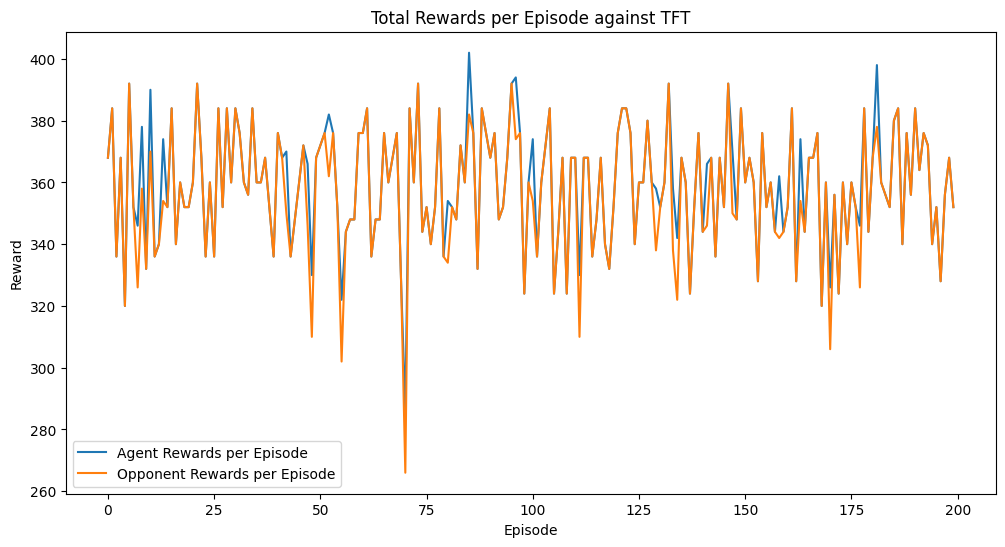

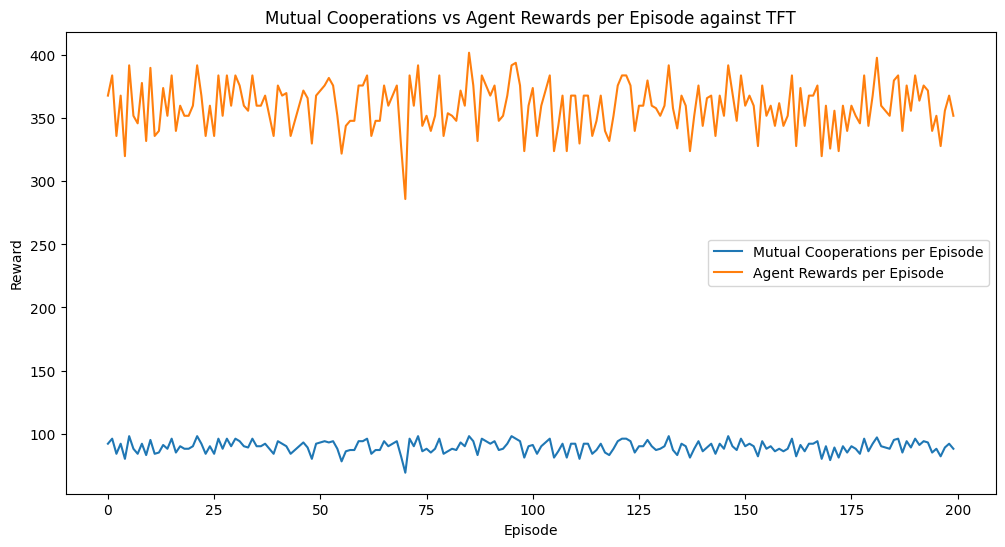

Testing against random strategy
Average Total Reward over 200 episodes: -241.32
Percentage of Mutual Cooperation: 0.4757


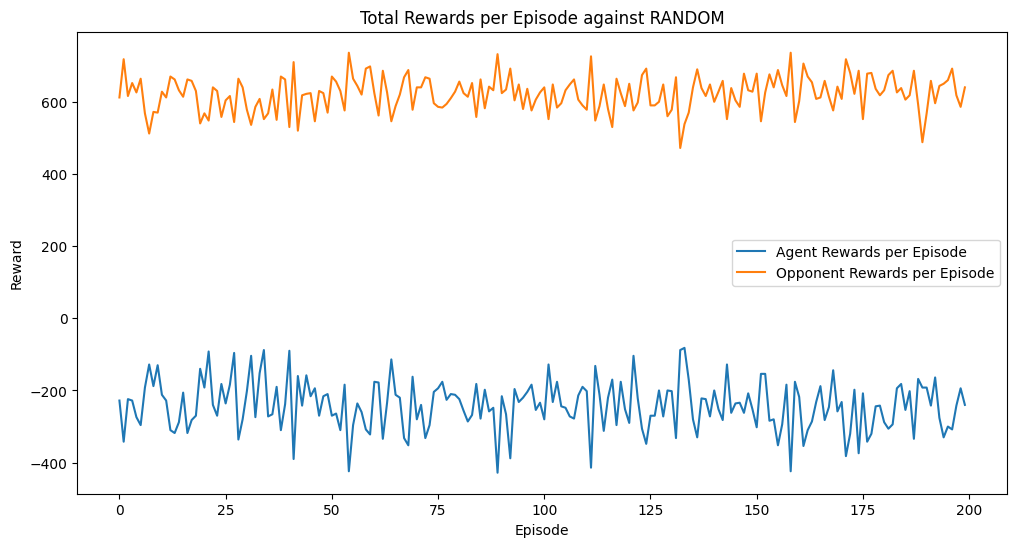

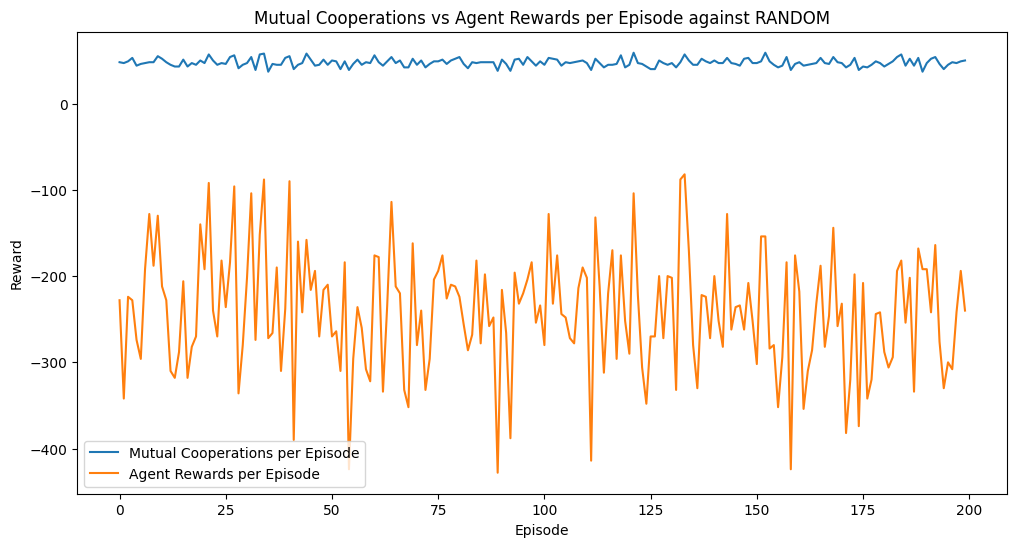

Testing against grim_trigger strategy
Average Total Reward over 200 episodes: 431.65
Percentage of Mutual Cooperation: 0.9472499999999999


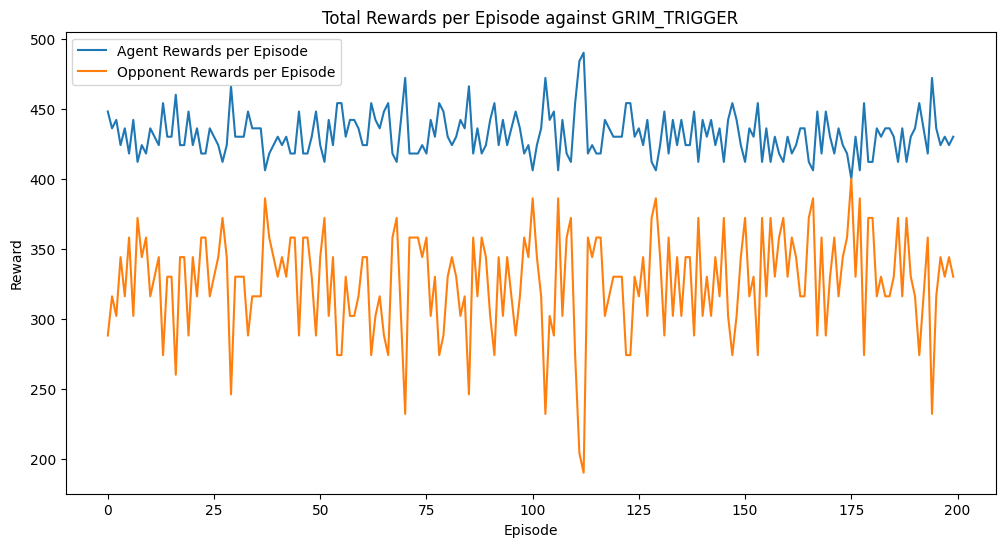

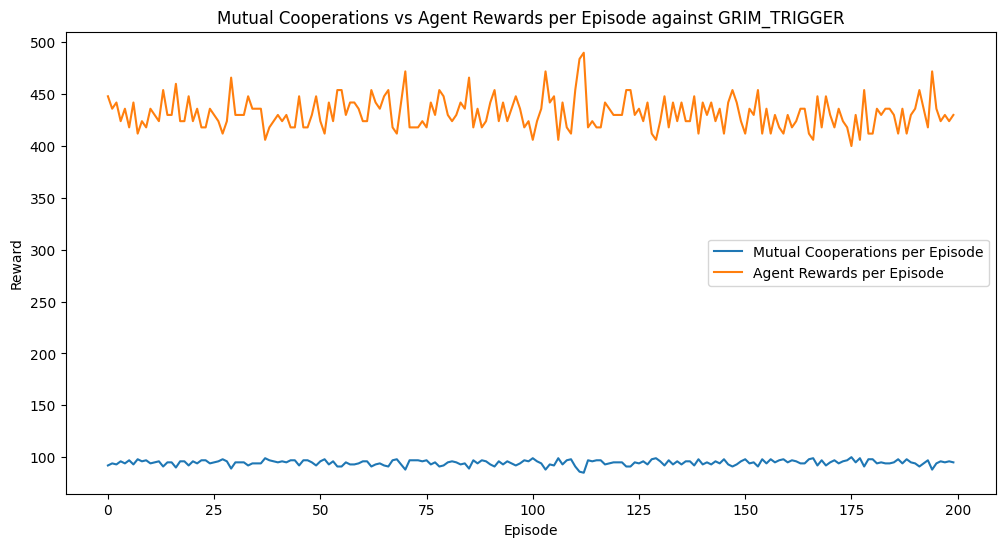

Testing against always_cooperate strategy
Average Total Reward over 200 episodes: 432.13
Percentage of Mutual Cooperation: 0.94645


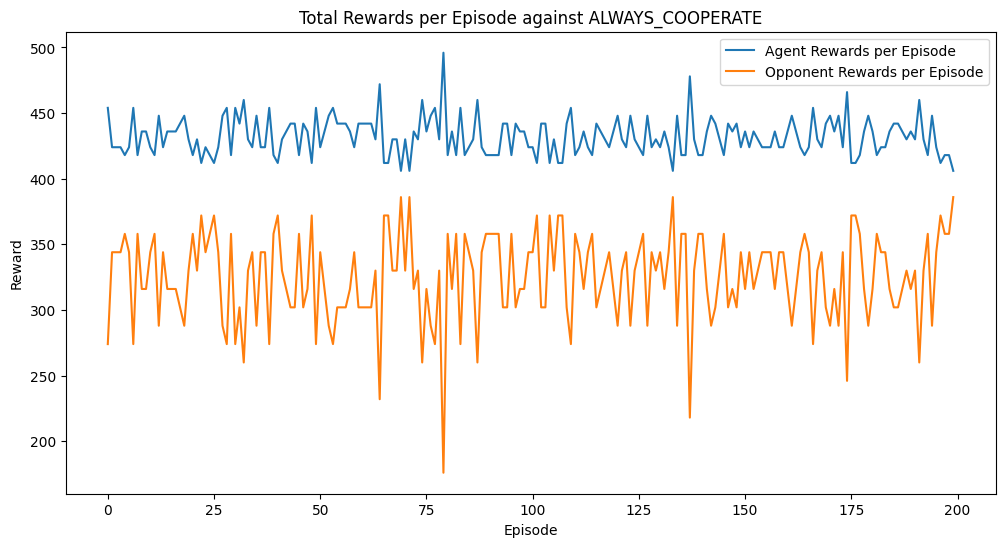

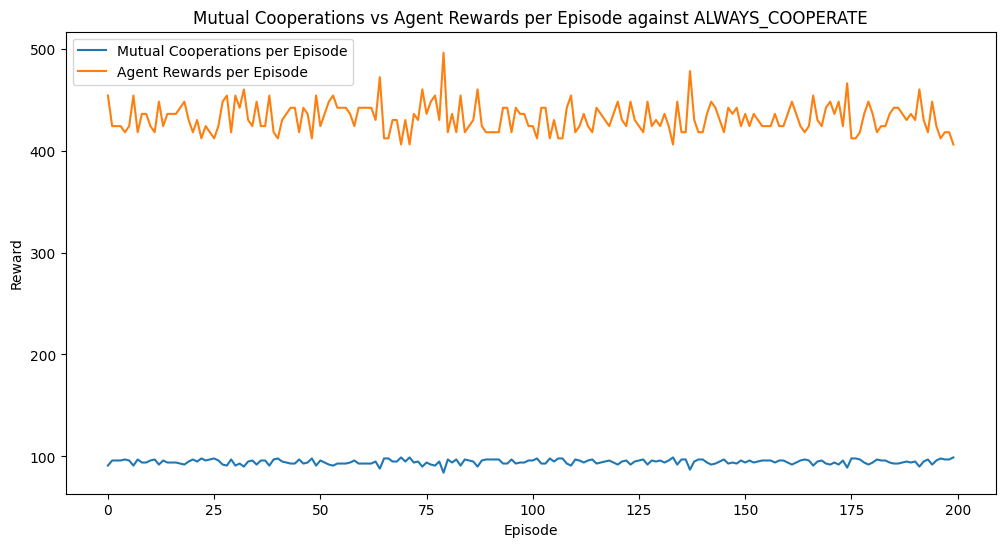

Testing against always_defect strategy
Average Total Reward over 200 episodes: -878.0
Percentage of Mutual Cooperation: 0.0


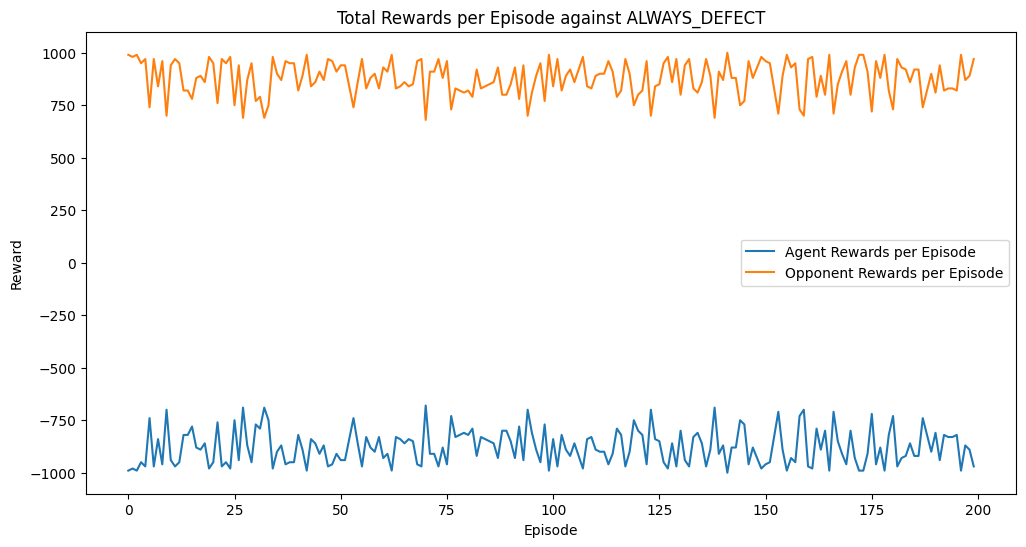

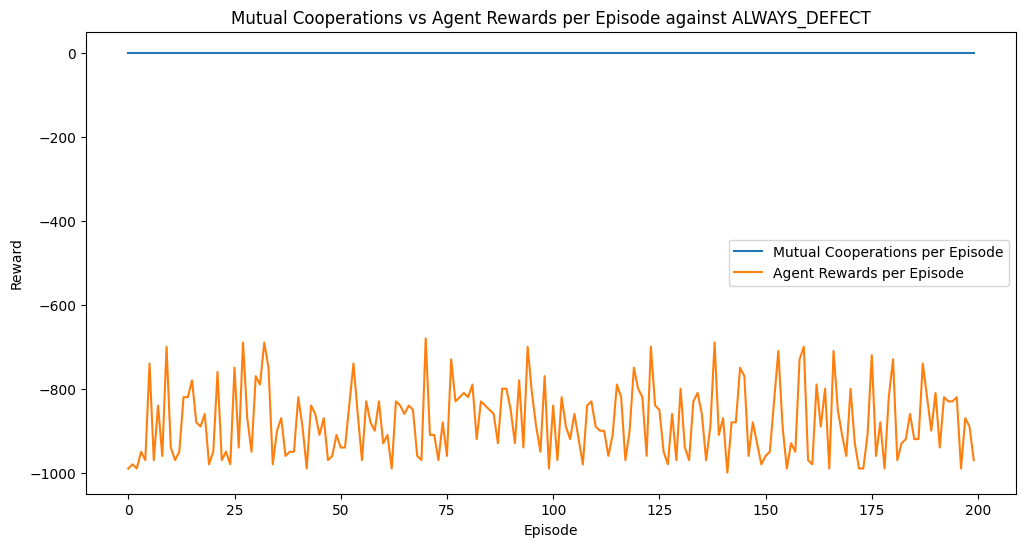

In [2]:
# Train and test the final models with plotting
print("Training and testing FFNN...")
ffnn_params = optimize_model(FFNN)
ffnn_results = test_against_strategies(FFNN, ffnn_params)

[I 2024-08-21 07:32:43,808] A new study created in memory with name: no-name-0f5dd2a2-acd8-49b7-a734-df5ec12065d4


Training and testing RNN...


/tmp/ipykernel_34/2130839232.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/tmp/ipykernel_34/2130839232.py:127: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.99, 0.999)
[I 2024-08-21 07:33:46,726] Trial 0 finished with value: 349.91 and parameters: {'hidden_size': 64, 'learning_rate': 0.000350915756599198, 'batch_size': 32, 'epsilon_decay': 0.99803197695977, 'target_update': 11}. Best is trial 0 with value: 349.91.
[I 2024-08-21 07:35:01,262] Trial 1 finished with value: 391.26 and parameters: {'hidden_size': 128, 'learning_rate': 0.002198288263878411, 'b

Best trial: {'hidden_size': 64, 'learning_rate': 0.005732409447477438, 'batch_size': 32, 'epsilon_decay': 0.9909698677336013, 'target_update': 17}
Episode 1, Total Reward: 102
Episode 2, Total Reward: 256
Episode 3, Total Reward: 344
Episode 4, Total Reward: 352
Episode 5, Total Reward: 392
Episode 6, Total Reward: 392
Episode 7, Total Reward: 400
Episode 8, Total Reward: 400
Episode 9, Total Reward: 400
Episode 10, Total Reward: 392
Episode 11, Total Reward: 392
Episode 12, Total Reward: 400
Episode 13, Total Reward: 384
Episode 14, Total Reward: 400
Episode 15, Total Reward: 384
Episode 16, Total Reward: 400
Episode 17, Total Reward: 392
Episode 18, Total Reward: 400
Episode 19, Total Reward: 392
Episode 20, Total Reward: 392
Episode 21, Total Reward: 400
Episode 22, Total Reward: 400
Episode 23, Total Reward: 400
Episode 24, Total Reward: 400
Episode 25, Total Reward: 400
Episode 26, Total Reward: 400
Episode 27, Total Reward: 400
Episode 28, Total Reward: 400
Episode 29, Total Rewa

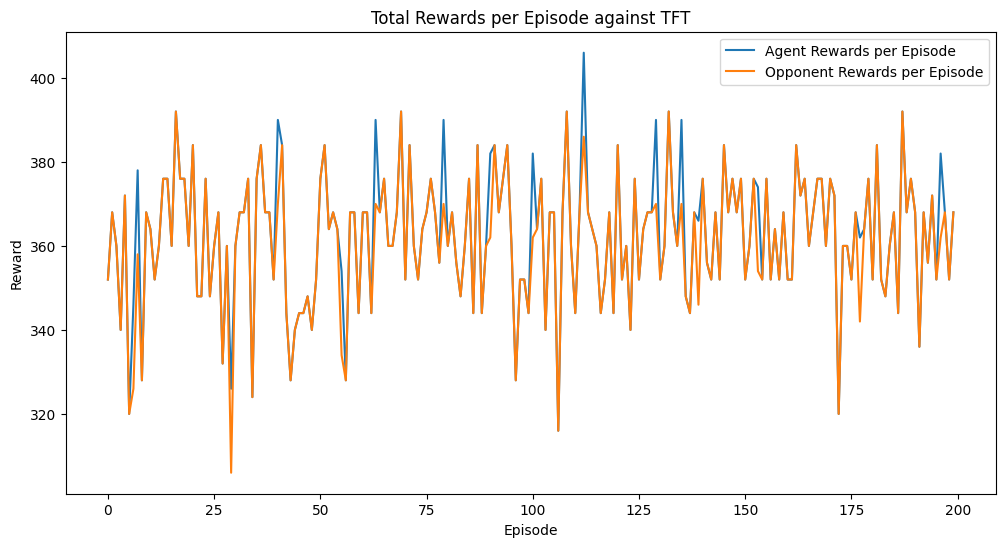

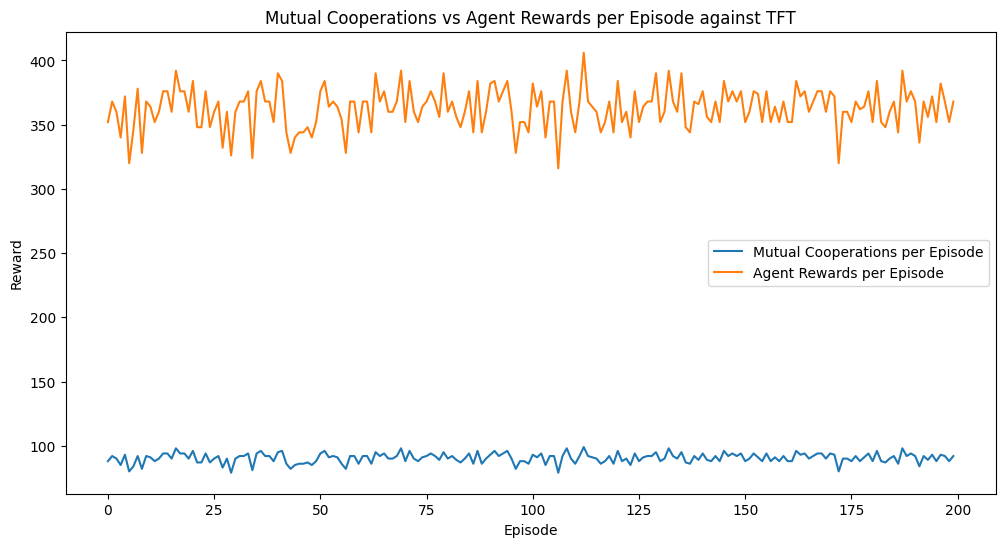

Testing against random strategy
Average Total Reward over 200 episodes: -249.08
Percentage of Mutual Cooperation: 0.4803


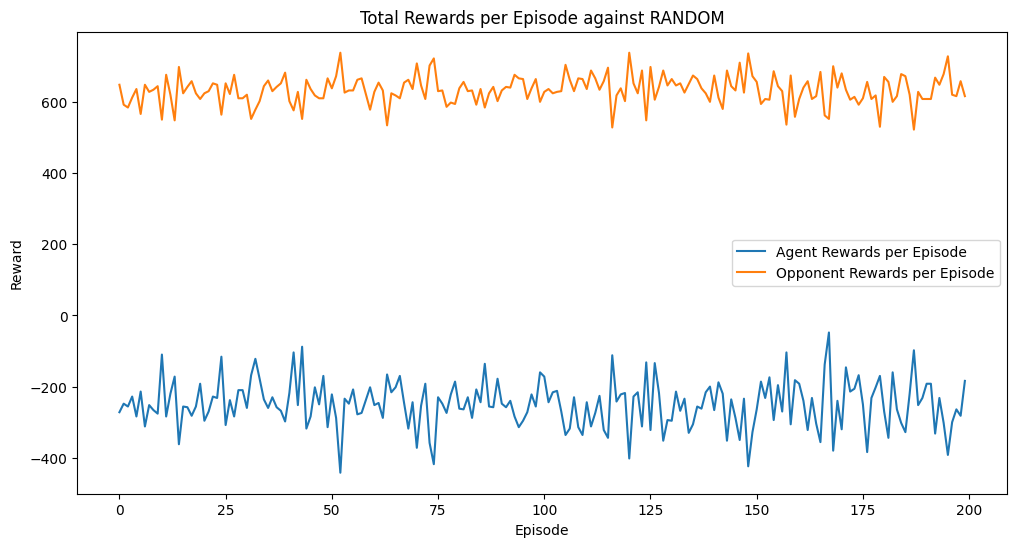

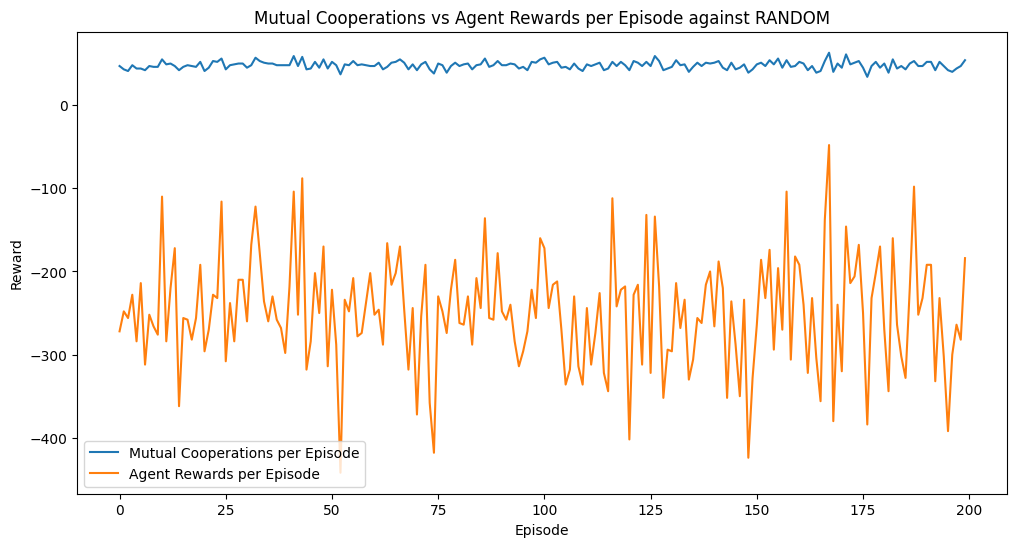

Testing against grim_trigger strategy
Average Total Reward over 200 episodes: 430.12
Percentage of Mutual Cooperation: 0.9498000000000001


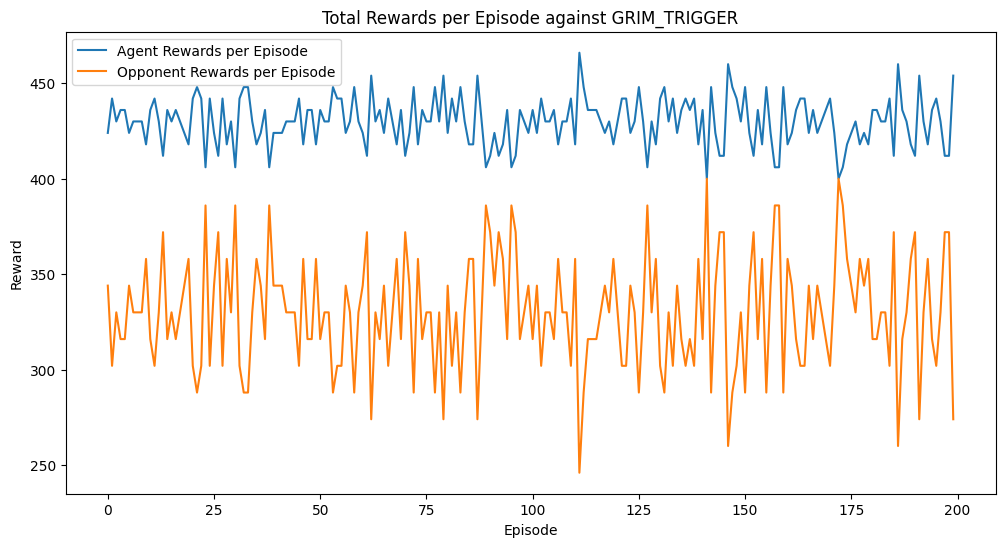

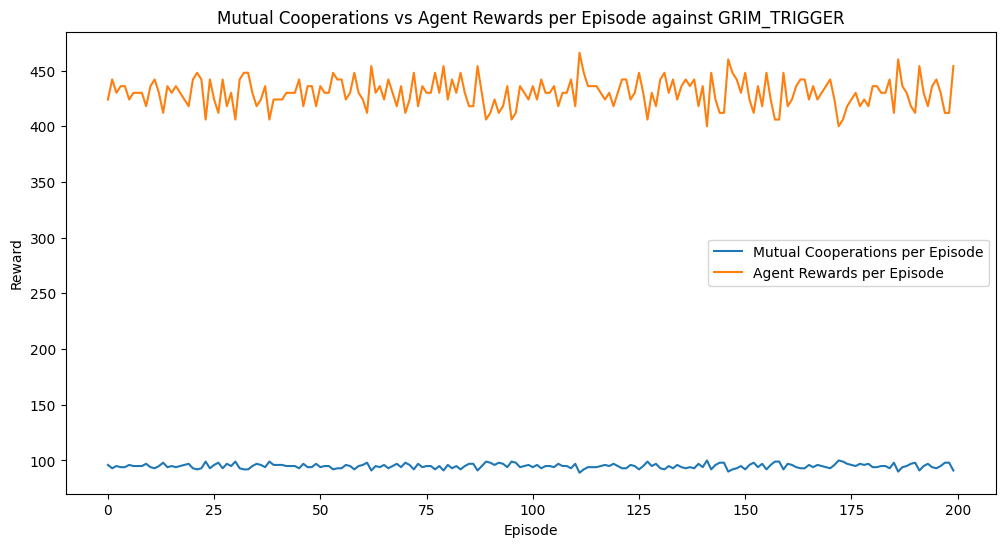

Testing against always_cooperate strategy
Average Total Reward over 200 episodes: 430.15
Percentage of Mutual Cooperation: 0.94975


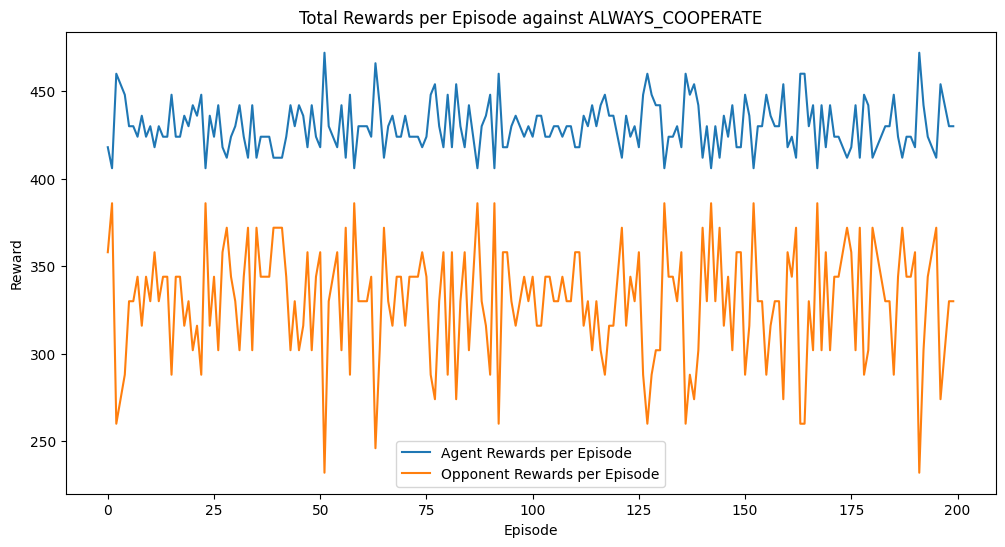

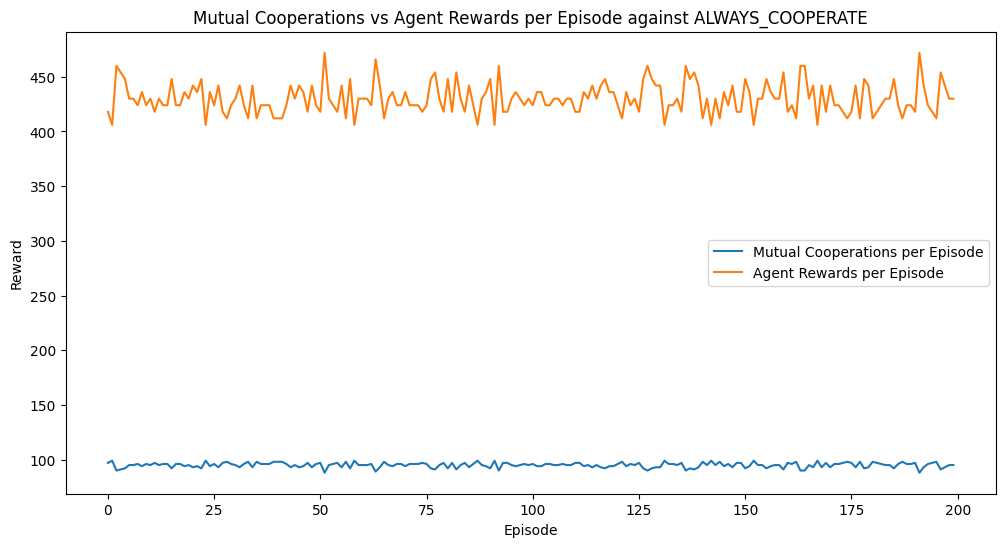

Testing against always_defect strategy
Average Total Reward over 200 episodes: -949.25
Percentage of Mutual Cooperation: 0.0


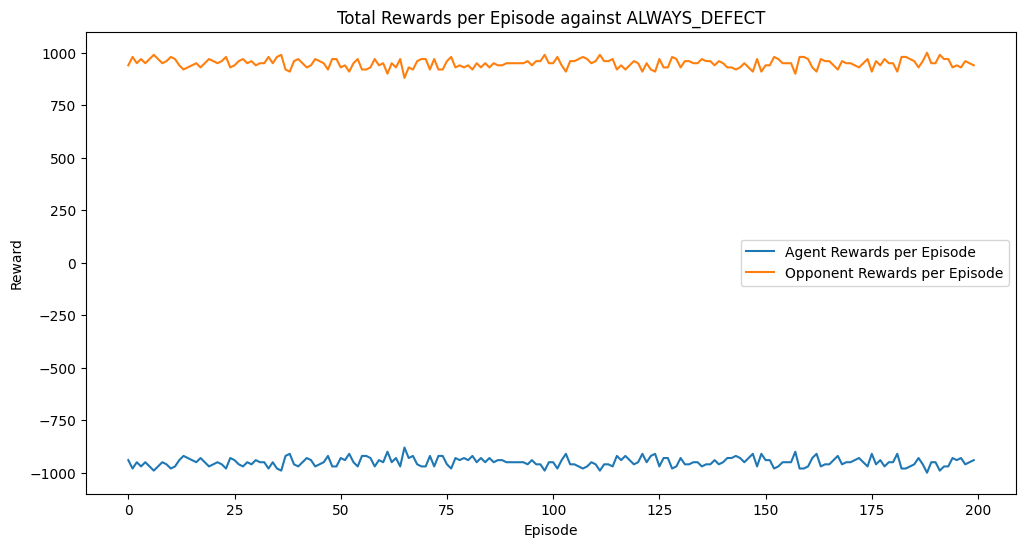

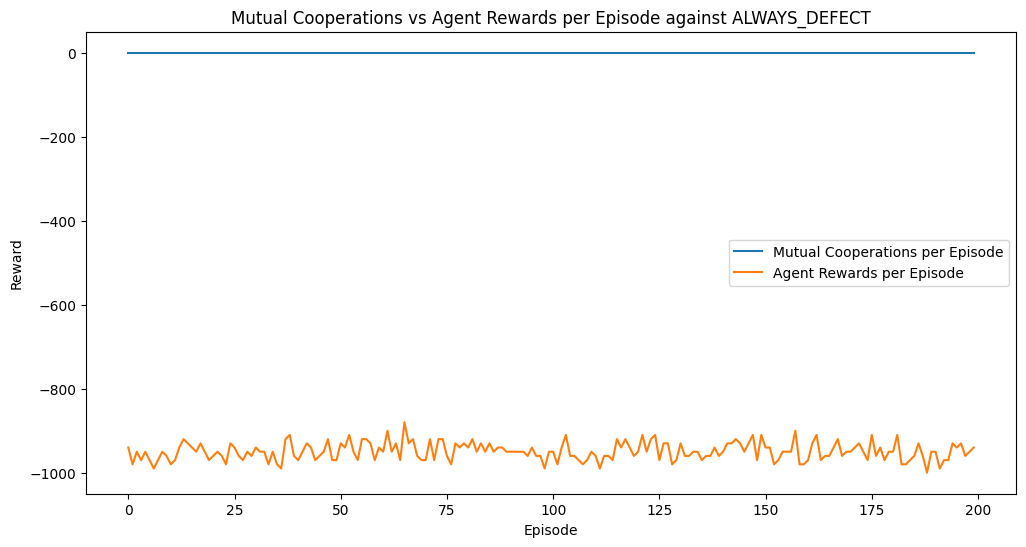

In [3]:
print("Training and testing RNN...")
rnn_params = optimize_model(RNN)
rnn_results = test_against_strategies(RNN, rnn_params)

[I 2024-08-21 08:35:36,614] A new study created in memory with name: no-name-6de28970-121e-4ee2-971e-2aef02aafd55


Training and testing LSTM...


/tmp/ipykernel_34/2130839232.py:125: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/tmp/ipykernel_34/2130839232.py:127: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.99, 0.999)
[I 2024-08-21 08:37:48,677] Trial 0 finished with value: 387.91 and parameters: {'hidden_size': 32, 'learning_rate': 0.0003107821980087665, 'batch_size': 64, 'epsilon_decay': 0.9937208761623381, 'target_update': 6}. Best is trial 0 with value: 387.91.
[I 2024-08-21 08:40:58,142] Trial 1 finished with value: 15.18 and parameters: {'hidden_size': 64, 'learning_rate': 0.0030588423636546246, '

Best trial: {'hidden_size': 32, 'learning_rate': 0.00021808863316737933, 'batch_size': 64, 'epsilon_decay': 0.9950464071399483, 'target_update': 20}
Episode 1, Total Reward: 148
Episode 2, Total Reward: 244
Episode 3, Total Reward: 344
Episode 4, Total Reward: 368
Episode 5, Total Reward: 360
Episode 6, Total Reward: 384
Episode 7, Total Reward: 400
Episode 8, Total Reward: 400
Episode 9, Total Reward: 400
Episode 10, Total Reward: 400
Episode 11, Total Reward: 392
Episode 12, Total Reward: 392
Episode 13, Total Reward: 392
Episode 14, Total Reward: 392
Episode 15, Total Reward: 392
Episode 16, Total Reward: 400
Episode 17, Total Reward: 400
Episode 18, Total Reward: 392
Episode 19, Total Reward: 400
Episode 20, Total Reward: 400
Episode 21, Total Reward: 392
Episode 22, Total Reward: 368
Episode 23, Total Reward: 392
Episode 24, Total Reward: 400
Episode 25, Total Reward: 384
Episode 26, Total Reward: 400
Episode 27, Total Reward: 400
Episode 28, Total Reward: 392
Episode 29, Total Re

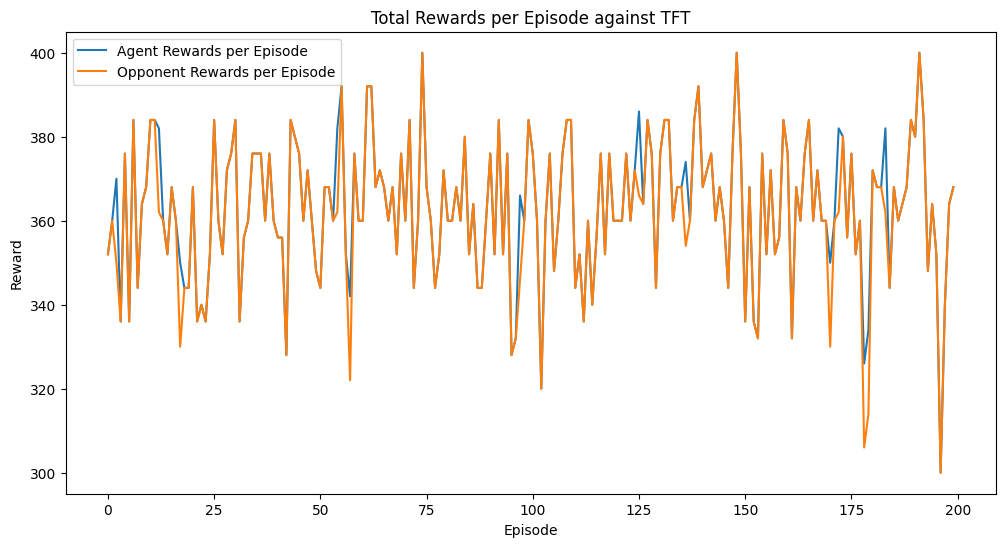

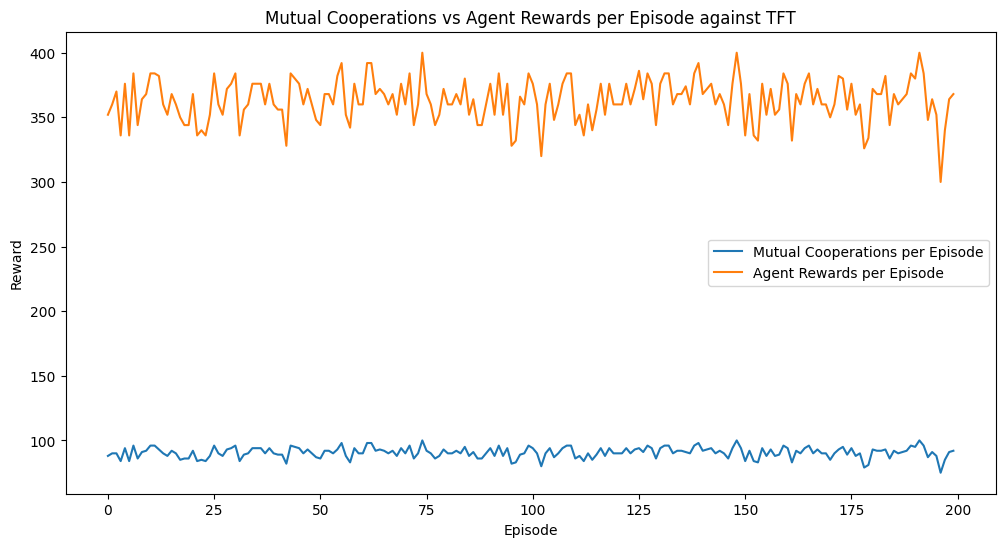

Testing against random strategy
Average Total Reward over 200 episodes: -264.68
Percentage of Mutual Cooperation: 0.47005


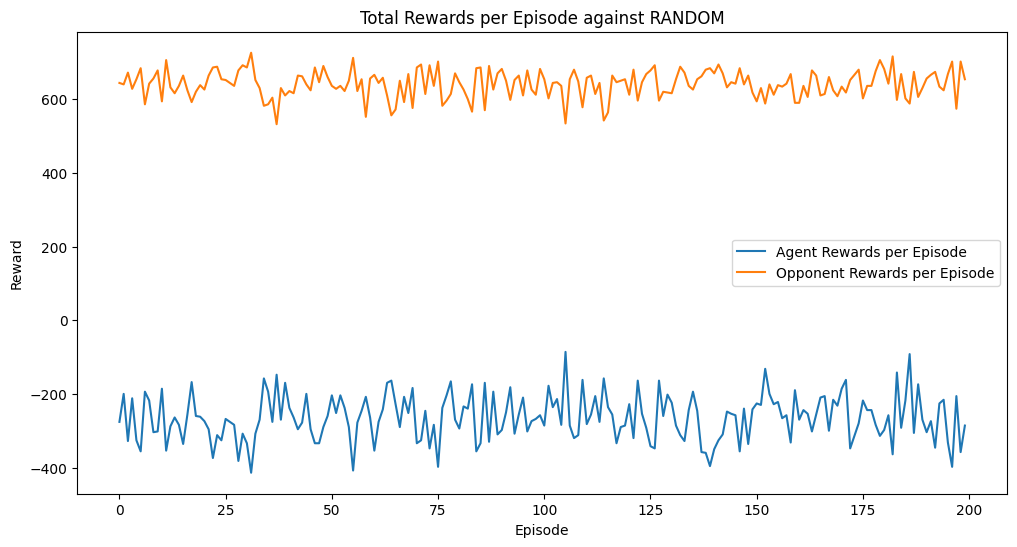

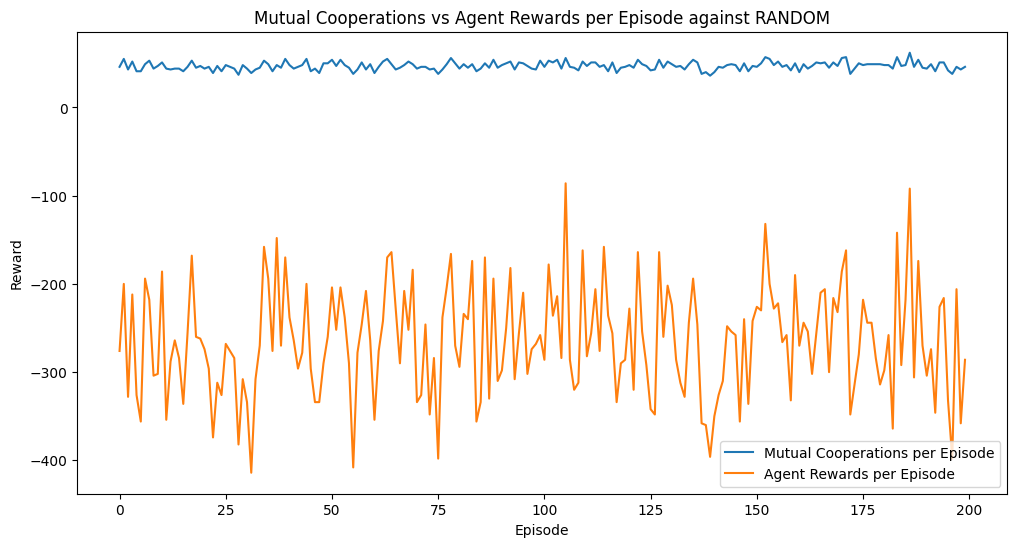

Testing against grim_trigger strategy
Average Total Reward over 200 episodes: 429.61
Percentage of Mutual Cooperation: 0.95065


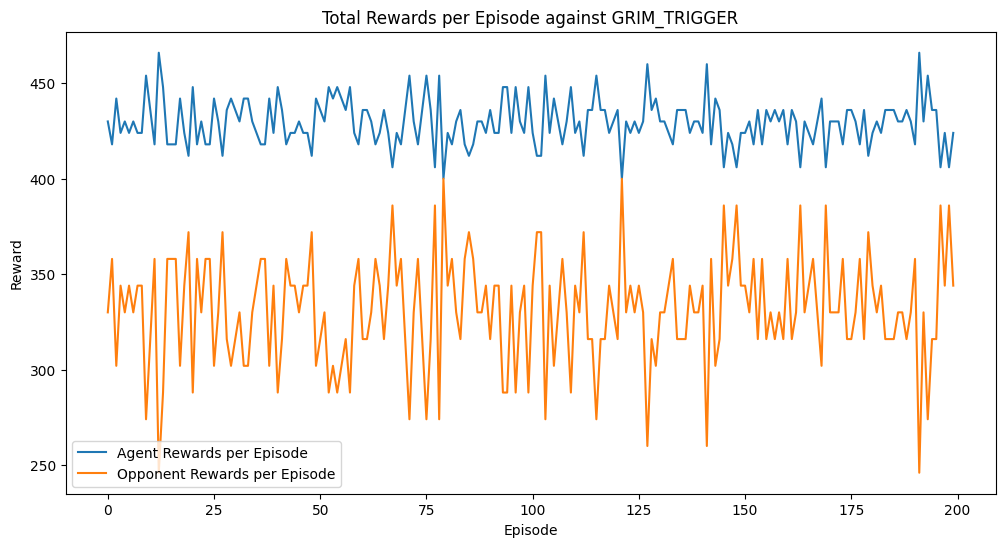

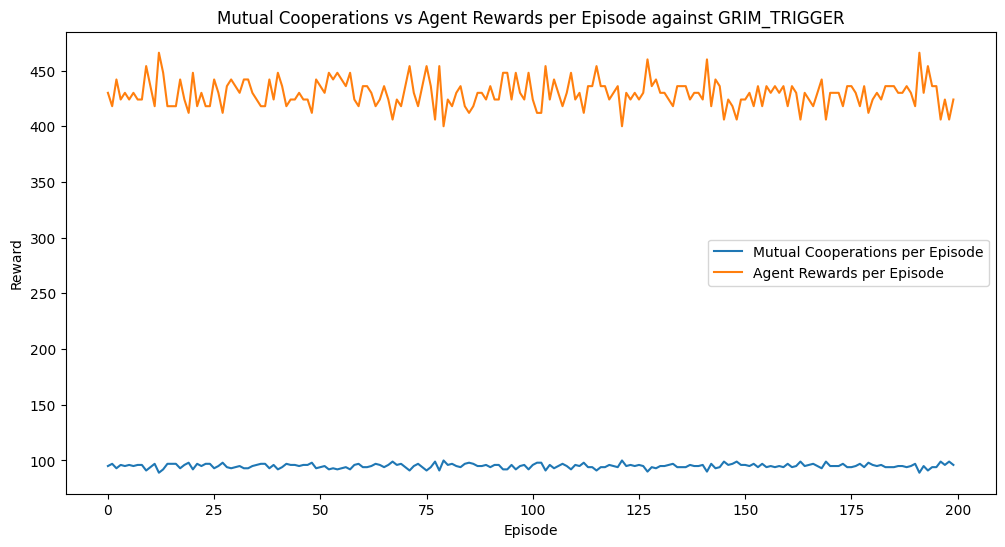

Testing against always_cooperate strategy
Average Total Reward over 200 episodes: 430.3
Percentage of Mutual Cooperation: 0.9495


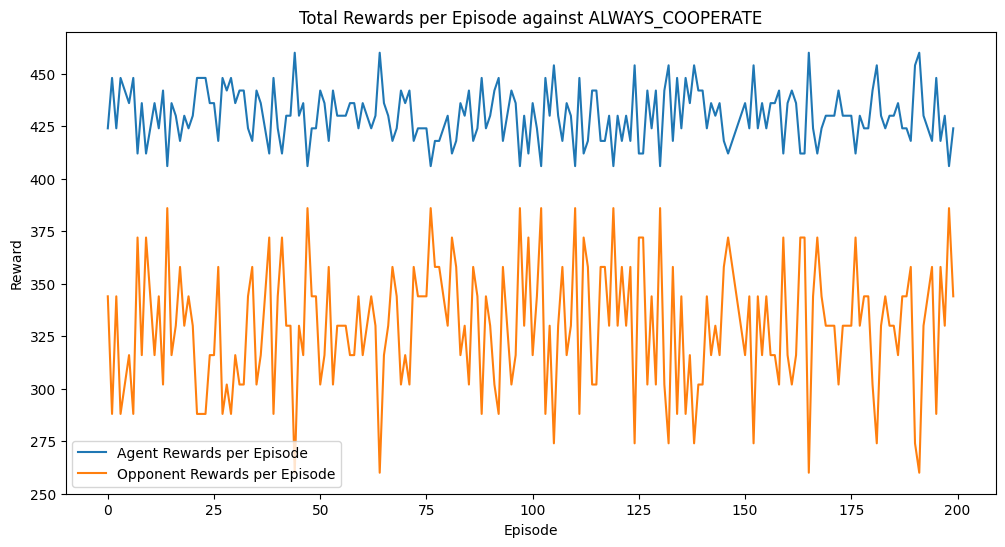

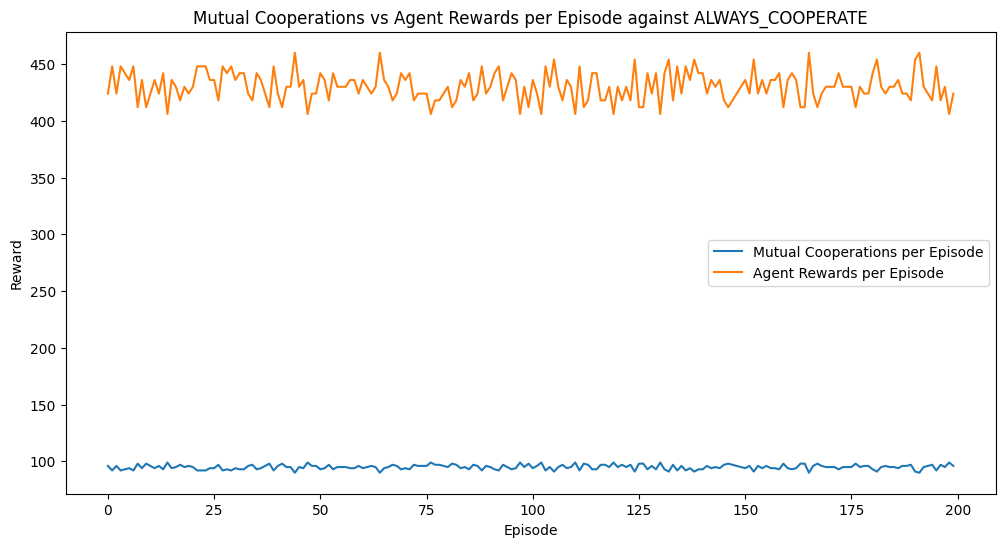

Testing against always_defect strategy
Average Total Reward over 200 episodes: -949.05
Percentage of Mutual Cooperation: 0.0


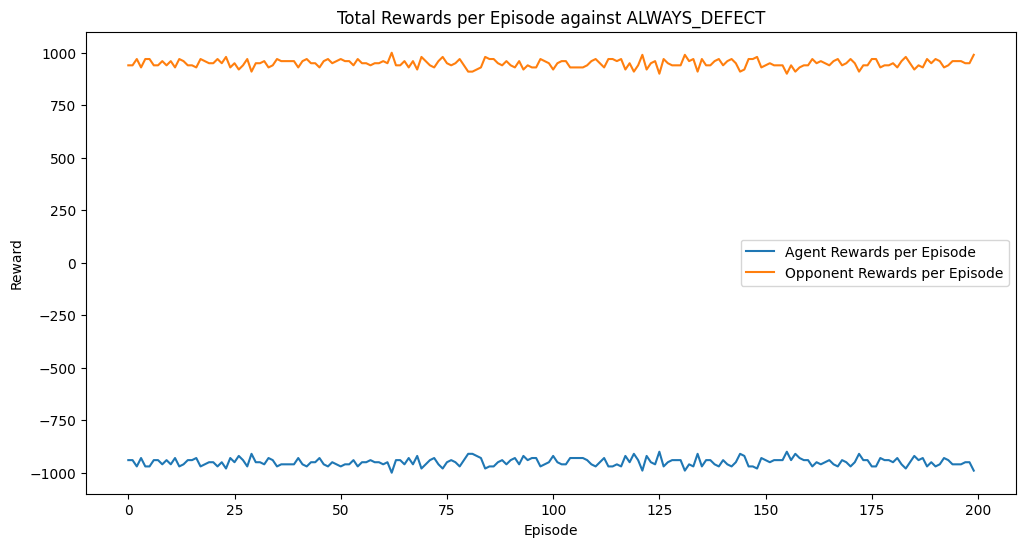

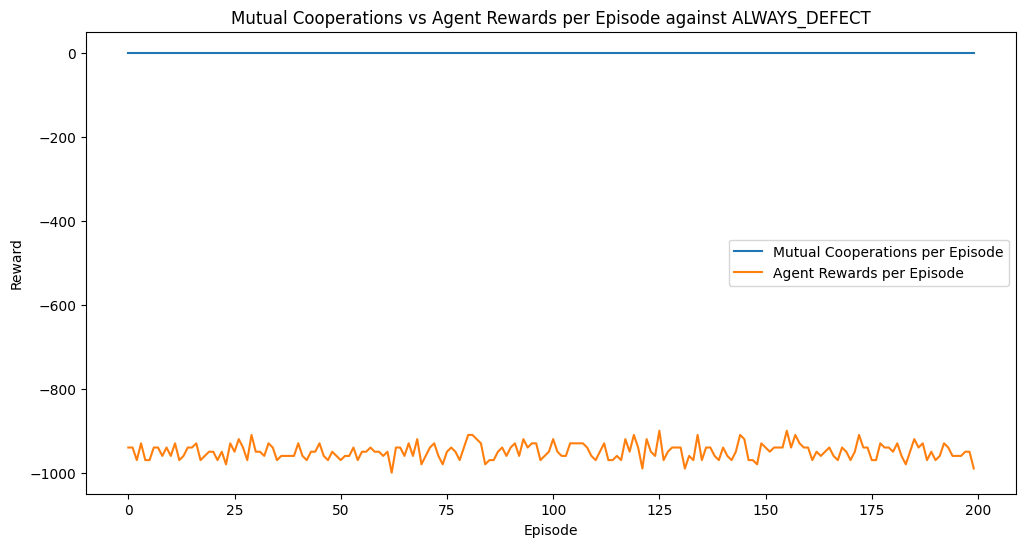

In [4]:
print("Training and testing LSTM...")
lstm_params = optimize_model(LSTM)
lstm_results = test_against_strategies(LSTM, lstm_params)

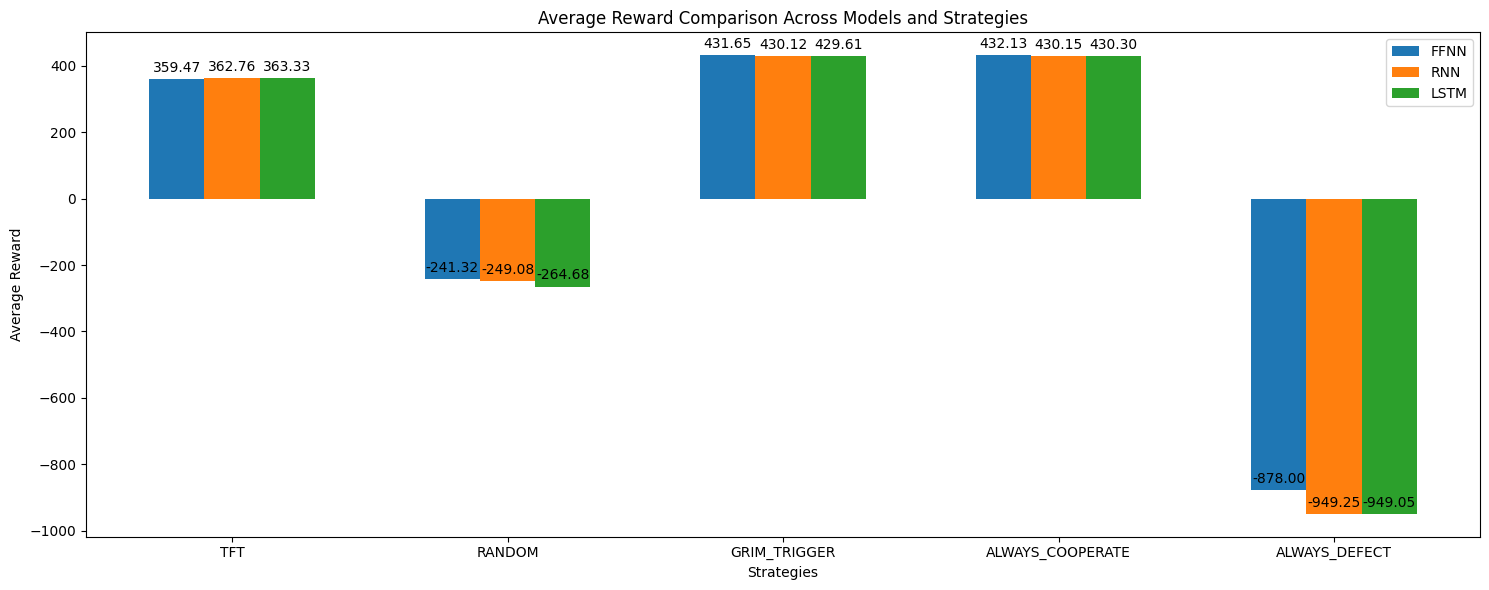

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_graph(ffnn_results, rnn_results, lstm_results, strategies):
    avg_rewards_ffnn = []
    avg_rewards_rnn = []
    avg_rewards_lstm = []

    for strategy in strategies:
        avg_rewards_ffnn.append(np.mean(ffnn_results[strategy][0]))  # Agent rewards for FFNN
        avg_rewards_rnn.append(np.mean(rnn_results[strategy][0]))    # Agent rewards for RNN
        avg_rewards_lstm.append(np.mean(lstm_results[strategy][0]))  # Agent rewards for LSTM

    x = np.arange(len(strategies))
    width = 0.2  

    fig, ax = plt.subplots(figsize=(15, 6))
    rects1 = ax.bar(x - width, avg_rewards_ffnn, width, label='FFNN')
    rects2 = ax.bar(x, avg_rewards_rnn, width, label='RNN')
    rects3 = ax.bar(x + width, avg_rewards_lstm, width, label='LSTM')

    ax.set_xlabel('Strategies')
    ax.set_ylabel('Average Reward')
    ax.set_title('Average Reward Comparison Across Models and Strategies')
    ax.set_xticks(x)
    ax.set_xticklabels([strategy.upper() for strategy in strategies])
    ax.legend()

    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)

    fig.tight_layout()
    plt.show()

strategies = ["tft", "random", "grim_trigger", "always_cooperate", "always_defect"]

plot_comparison_graph(ffnn_results, rnn_results, lstm_results, strategies)


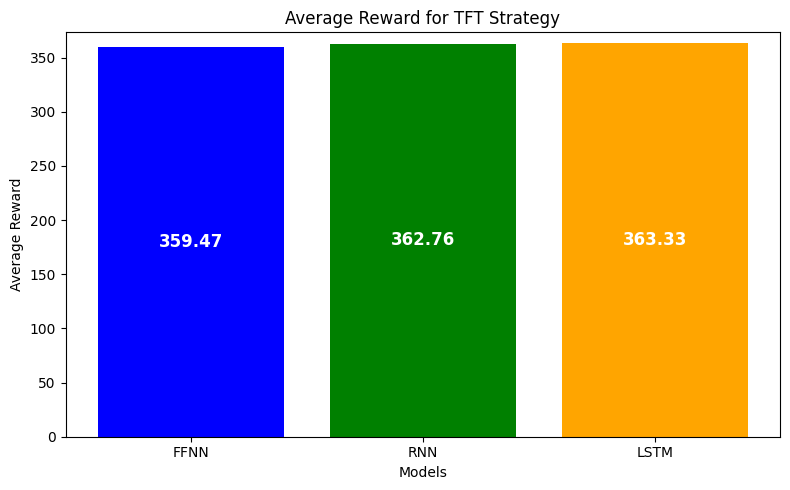

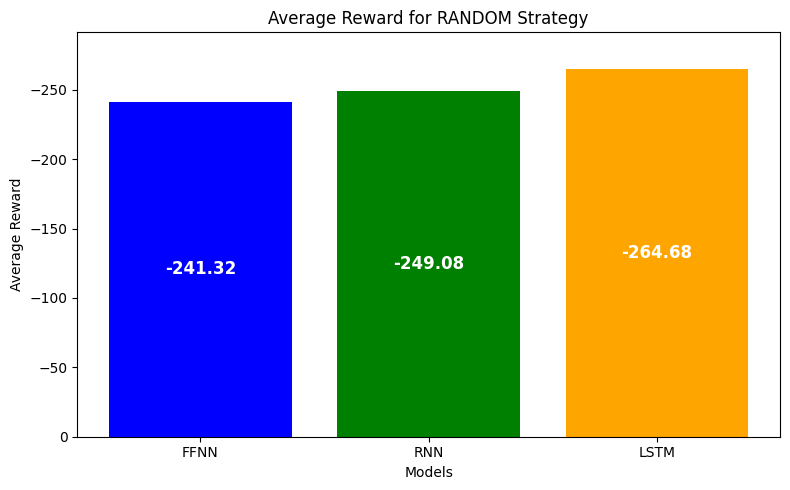

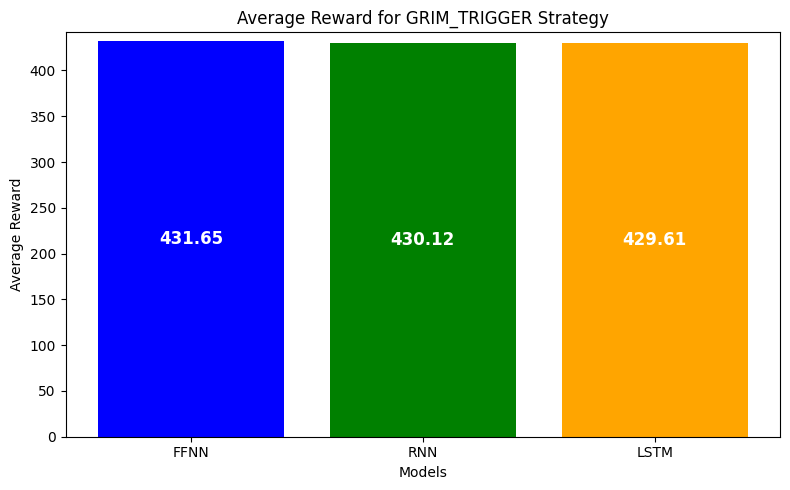

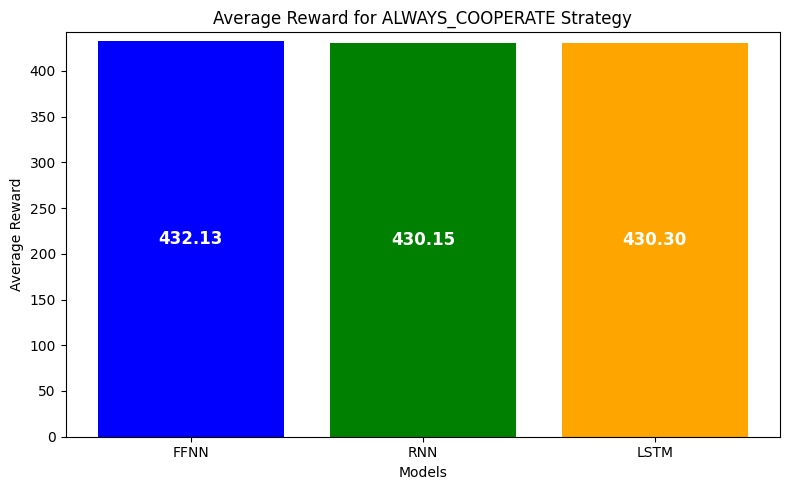

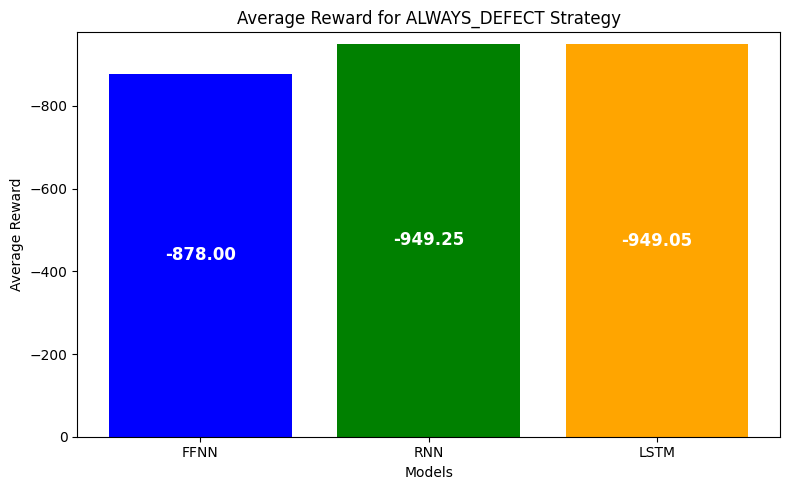

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_separate_graphs(ffnn_results, rnn_results, lstm_results, strategies):
    for strategy in strategies:
        avg_reward_ffnn = np.mean(ffnn_results[strategy][0])  # Agent rewards for FFNN
        avg_reward_rnn = np.mean(rnn_results[strategy][0])    # Agent rewards for RNN
        avg_reward_lstm = np.mean(lstm_results[strategy][0])  # Agent rewards for LSTM

        models = ['FFNN', 'RNN', 'LSTM']
        avg_rewards = [avg_reward_ffnn, avg_reward_rnn, avg_reward_lstm]

        fig, ax = plt.subplots(figsize=(8, 5))
        bars = ax.bar(models, avg_rewards, color=['blue', 'green', 'orange'])

        ax.set_xlabel('Models')
        ax.set_ylabel('Average Reward')
        ax.set_title(f'Average Reward for {strategy.upper()} Strategy')

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height / 2.0, f'{height:.2f}',
                    ha='center', va='center', color='white', fontsize=12, fontweight='bold')
        
        if strategy=='random':
            plt.ylim(0, max(avg_rewards) - 50)
        elif strategy=='always_defect':
            plt.ylim(0, max(avg_rewards) - 100)
        else:
            plt.ylim(0, max(avg_rewards) + 10)
        plt.tight_layout()
        plt.show()

strategies = ["tft", "random", "grim_trigger", "always_cooperate", "always_defect"]
plot_separate_graphs(ffnn_results, rnn_results, lstm_results, strategies)
